<a href="https://colab.research.google.com/github/Braj-01/doubleMachineLearningModel/blob/main/PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install econml causalml scikit-learn pandas statsmodels matplotlib


In [2]:
import pandas as pd
import numpy as np


In [3]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from econml.dml import LinearDML
import statsmodels.api as sm

In [4]:
from econml.dml import CausalForestDML
import matplotlib.pyplot as plt

**Data Loading and Preprocessing**

In [5]:
df = pd.read_csv("india_yearly_full_release_long_format.csv")

In [6]:
# Filter only "Capacity" category
df_capacity = df[df["Category"] == "Capacity"]


In [7]:
# Pivot to wide format: one row per (State, Year)
df_pivot = df_capacity.pivot_table(
    index=["State", "Year"],
    columns="Variable",
    values="Value",
    aggfunc="sum"
).reset_index()

In [8]:
# Rename relevant columns
df_pivot = df_pivot.rename(columns={
    'Clean': 'Capacity_Clean',
    'Fossil': 'Capacity_Fossil',
    'Renewables': 'Capacity_Renewables',
    'Gas and Other Fossil': 'Capacity_Gas_Other',
    'Hydro, Bioenergy and Other Renewables': 'Capacity_Other_Renewables'
})

In [9]:
# Define Treatment:
treated_states = ['Tamil Nadu', 'Gujarat', 'Rajasthan', 'Karnataka', 'Maharashtra']
df_pivot['Treatment'] = df_pivot['State'].isin(treated_states).astype(int)


In [10]:
# Drop rows with missing values
df_model = df_pivot.dropna(subset=[
    'Capacity_Renewables', 'Capacity_Fossil',
    'Capacity_Clean', 'Capacity_Gas_Other', 'Capacity_Other_Renewables'
])
print(df_model['Treatment'].value_counts())


Treatment
0    187
1     30
Name: count, dtype: int64


In [11]:
# Define outcome, treatment, and covariates
Y = df_model["Capacity_Renewables"].values
T = df_model["Treatment"].values
X = df_model[[
    "Capacity_Fossil", "Capacity_Clean",
    "Capacity_Gas_Other", "Capacity_Other_Renewables"
]].fillna(0).values

**OLS and DML**

In [12]:
#  OLS
X_ols = sm.add_constant(X)
ols_model = sm.OLS(Y, X_ols[:, [0, 1]]).fit()  # only const + Treatment
print("OLS Summary:\n", ols_model.summary())

OLS Summary:
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     2942.
Date:                Mon, 07 Jul 2025   Prob (F-statistic):          2.06e-127
Time:                        01:30:28   Log-Likelihood:                -2231.9
No. Observations:                 217   AIC:                             4468.
Df Residuals:                     215   BIC:                             4475.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        133.6515    510.378      

In [13]:
# -------- Double Machine Learning ----------
dml = LinearDML(
    model_y=GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42),
    model_t=GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42),
    discrete_treatment=True,
    random_state=123
)


In [14]:
dml.fit(Y, T, X=X)



In [15]:
ate_dml = dml.effect(X)
ate_ci = dml.effect_interval(X)


In [16]:
ate_dml = ate_dml / 1000  # convert to GW for example


In [17]:
print(f"\nDML Estimated ATE (mean): {np.mean(ate_dml):.4f}")
print(f"DML 95% CI: [{ate_ci[0].mean():.4f}, {ate_ci[1].mean():.4f}]")


DML Estimated ATE (mean): 687.5944
DML 95% CI: [-5116025.1704, 6491213.9341]


**Causal Forest and Plotting**

In [18]:
# -------- Causal Forest ----------
cf = CausalForestDML(
    model_y=GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42),
    model_t=GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42),
    discrete_treatment=True,
    n_estimators=1000,
    min_samples_leaf=10,
    max_depth=10,
    random_state=123
)

In [19]:
cf.fit(Y, T, X=X)
cate_cf = cf.effect(X)

In [20]:
print(f"Causal Forest CATE shape: {cate_cf.shape}")
print(f"First 5 CATE estimates: {cate_cf[:5].round(4)}")

Causal Forest CATE shape: (217,)
First 5 CATE estimates: [-682.112  -682.112  -682.112  -686.5367 -686.5367]


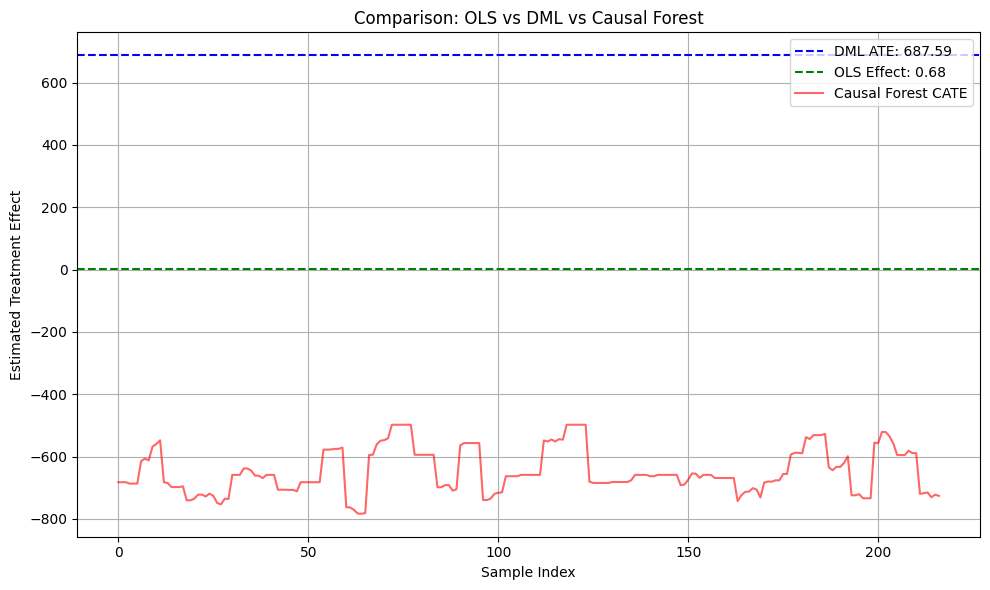

In [21]:
# -------- Plot all three results ----------
plt.figure(figsize=(10, 6))
plt.axhline(y=np.mean(ate_dml), color='blue', linestyle='--', label=f'DML ATE: {np.mean(ate_dml):.2f}')
plt.axhline(y=ols_model.params[1], color='green', linestyle='--', label=f'OLS Effect: {ols_model.params[1]:.2f}')
plt.plot(cate_cf, color='red', alpha=0.6, label='Causal Forest CATE')
plt.xlabel('Sample Index')
plt.ylabel('Estimated Treatment Effect')
plt.title('Comparison: OLS vs DML vs Causal Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

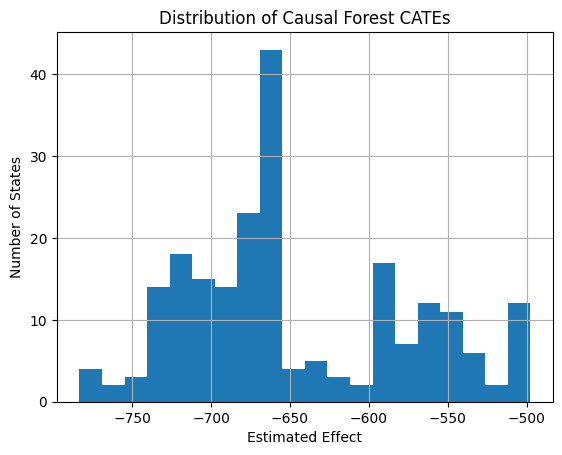

In [22]:
import matplotlib.pyplot as plt
plt.hist(cate_cf, bins=20)
plt.title("Distribution of Causal Forest CATEs")
plt.xlabel("Estimated Effect")
plt.ylabel("Number of States")
plt.grid(True)
plt.show()
